# Baseline Architecture
* test qdanalysis package functions
* rough out ML process

In [1]:
#auto reloading magic
%load_ext autoreload
%autoreload 2

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import qdanalysis.strokedecomposition as sd
import qdanalysis.preprocessing as prep

from qdanalysis.models import adapt_resnet50

2024-01-09 19:55:24.192211: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


this is going to have to be done on a per file basis via path

In [2]:
#test data
eng_test = cv.imread(r'CERUG_EN_Test.png')
print(len(eng_test.shape))

eng_test_bin = prep.preprocess(eng_test) #threshold and invert image at the same time to work with foreground elements (value=1)

3
3


/tmp/ipykernel_22736/1345006509.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


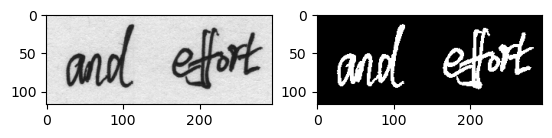

In [3]:
fig = plt.figure()
eng_ax = plt.subplot(1, 2, 1)
eng_ax.imshow(eng_test, cmap='gray')
eng_bin_Ax = plt.subplot(1, 2, 2)
eng_bin_Ax.imshow(eng_test_bin, cmap='gray')
fig.show()

In [4]:
test = sd.simple_stroke_segment(eng_test_bin)
len(test)

52

/tmp/ipykernel_22736/3557466613.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  stroke_fig.show()


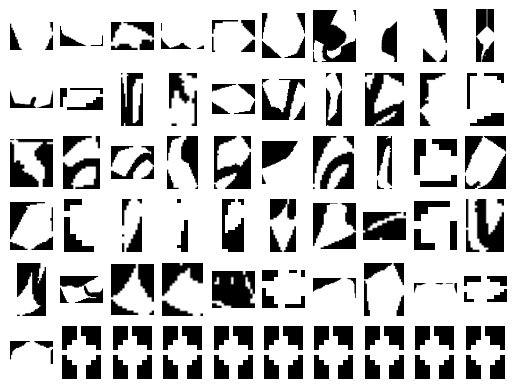

In [5]:
stroke_fig, stroke_axes = plt.subplots(6, 10)
count = 0
for row in stroke_axes:
    for ax in row:
        ax.axis('off')
        ax.imshow(test[count], cmap='gray')
        count = min(count+1, len(test)-1)

stroke_fig.show()

In [6]:
model = adapt_resnet50((64, 64, 3))
model.compile()

2024-01-09 19:55:28.991701: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-01-09 19:55:28.992598: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-01-09 19:55:29.028890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2024-01-09 19:55:29.028971: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-01-09 19:55:29.030349: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-01-09 19:55:29.030487: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2024-

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              2049000   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10010     
Total params: 25,646,722
Trainable params: 2,059,010
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
height, width = test[0].shape
height, width

h = w = 64
h_d = h - height
w_d = h - width

top, bottom = h_d // 2, h_d - (h_d // 2)
top, bottom

left, right = w_d // 2, w_d - (w_d // 2)
left, right

test_padded = cv.copyMakeBorder(test[0].astype(float), top, bottom, left, right, cv.BORDER_CONSTANT, value = 0)
test_padded = cv.cvtColor(test_padded.astype(np.float32), cv.COLOR_GRAY2RGB)

In [9]:
test_padded.shape

(64, 64, 3)

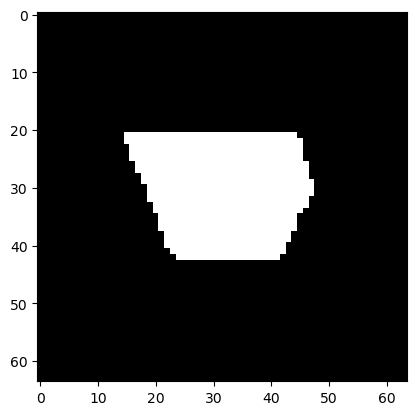

In [10]:
plt.imshow(test_padded)

In [11]:
fake_batch = test_padded.reshape(-1, 64, 64, 3)
model.predict(fake_batch)

2024-01-09 19:55:31.055146: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-01-09 19:55:31.072105: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2024-01-09 19:55:31.566340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-01-09 19:55:31.708629: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-01-09 19:55:32.504554: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-01-09 19:55:32.571369: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


array([[0.0412112 , 0.1847381 , 0.11722608, 0.10100427, 0.10139006,
        0.0731457 , 0.06202245, 0.0783232 , 0.15940197, 0.08153701]],
      dtype=float32)